In [ ]:
# Import necessary libraries
# Standard suite for Deep Learning (TensorFlow/Keras), Data Manipulation (Pandas/Numpy), 
# Scientific Computing (Scipy), Plotting (Matplotlib), and Linear Operators (Pylops)
import pandas as pd
import pylops
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Conv2D,Input,Conv1D
from tensorflow.keras.models import Model
from PIL import *
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
from tensorflow.keras.layers import Dropout
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import scipy.io as sio
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load Ground Truth Model (Vp, Vs, Density)
model_EI = sio.loadmat('model_EI.mat')
model_EI = model_EI['foo']
model_EI.shape

(200, 350, 3)

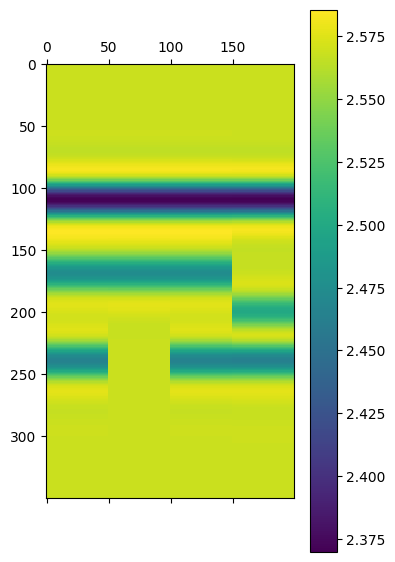

In [ ]:
# Visualize Density Model
plt.matshow(model_EI[:,:,2].T)
plt.colorbar()

In [ ]:
# Normalization Function (Min-Max)
def minmax(data,Min,Max):
    sample = (data - Min)/ (Max - Min)
    return sample

In [ ]:
# Load Multi-Angle Seismic Data (Near, Mid, Far stacks)
near = sio.loadmat('near.mat')
near = near['foo']
near = np.transpose(near,(1,2,0))

mid = sio.loadmat('mid.mat')
mid = mid['foo']
mid = np.transpose(mid,(1,2,0))

far = sio.loadmat('far.mat')
far = far['foo']
far = np.transpose(far,(1,2,0))
far.shape

(200, 350, 3)

In [ ]:
# Select Training Traces (Indices: 25, 75, 125, 175) for Seismic Data
near_1 = near[25,:,0]
near_2 = near[75,:,0]
near_3 = near[125,:,0]
near_4 = near[175,:,0]

mid_1 = mid[25,:,0]
mid_2 = mid[75,:,0]
mid_3 = mid[125,:,0]
mid_4 = mid[175,:,0]

far_1 = far[25,:,0]
far_2 = far[75,:,0]
far_3 = far[125,:,0]
far_4 = far[175,:,0]

In [ ]:
# Select Training Traces for Ground Truth Labels
VP1 = model_EI[25,:,0]
VP2 = model_EI[75,:,0]
VP4 = model_EI[175,:,0]

VS1 = model_EI[25,:,1]
VS2 = model_EI[75,:,1]
VS4 = model_EI[175,:,1]

DEN1 = model_EI[25,:,2]
DEN2 = model_EI[75,:,2]
DEN4 = model_EI[175,:,2]

In [ ]:
# Calculate Statistics for Normalization
near_1min = np.min(near_1)
near_1max = np.max(near_1)

mid_1min = np.min(mid_1)
mid_1max = np.max(mid_1)

far_1min = np.min(far_1)
far_1max = np.max(far_1)

VP_1min = np.min(VP1)
VP_1max = np.max(VP1)

VS_1min = np.min(VS1)
VS_1max = np.max(VS1)

DEN_1min = np.min(DEN1)
DEN_1max = np.max(DEN1)

In [ ]:
# Normalize Seismic Data
near_1S = minmax(near_1,near_1min,near_1max)
near_2S = minmax(near_2,near_1min,near_1max)
near_3S = minmax(near_3,near_1min,near_1max)
near_4S = minmax(near_4,near_1min,near_1max)

mid_1S = minmax(mid_1,near_1min,near_1max)
mid_2S = minmax(mid_2,near_1min,near_1max)
mid_3S = minmax(mid_3,near_1min,near_1max)
mid_4S = minmax(mid_4,near_1min,near_1max)

far_1S = minmax(far_1,near_1min,near_1max)
far_2S = minmax(far_2,near_1min,near_1max)
far_3S = minmax(far_3,near_1min,near_1max)
far_4S = minmax(far_4,near_1min,near_1max)

In [ ]:
# Normalize Ground Truth Labels
VP_1 = minmax(VP1,VP_1min,VP_1max)
VP_2 = minmax(VP2,VP_1min,VP_1max)
VP_4 = minmax(VP4,VP_1min,VP_1max)

VS_1 = minmax(VS1,VS_1min,VS_1max)
VS_2 = minmax(VS2,VS_1min,VS_1max)
VS_4 = minmax(VS4,VS_1min,VS_1max)

DEN_1 = minmax(DEN1,DEN_1min,DEN_1max)
DEN_2 = minmax(DEN2,DEN_1min,DEN_1max)
DEN_4 = minmax(DEN4,DEN_1min,DEN_1max)

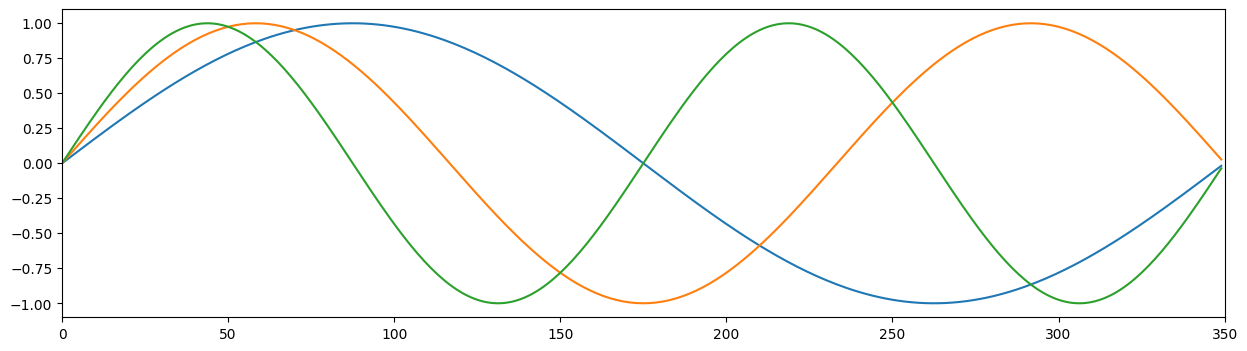

In [ ]:
# Feature Engineering: Phase Encoding
# Generate sine waves of different frequencies as auxiliary features
T = 350  # Time samples
f = 1 / T  # Base frequency
x1 = np.arange(350)
Phase1 = np.sin(2 * np.pi * f * x1)  # 2nd harmonic

Phase2 = np.sin(3 * np.pi * f * x1)  # 3rd harmonic

Phase4 = np.sin(4 * np.pi * f * x1)  # 4th harmonic

plt.figure(figsize=(15,4))
plt.plot(x1, Phase1, label='Phase1') 
plt.plot(x1, Phase2, label='Phase2') 
plt.plot(x1, Phase4, label='Phase4') 
plt.xlim(0,350)
plt.legend()
plt.show()

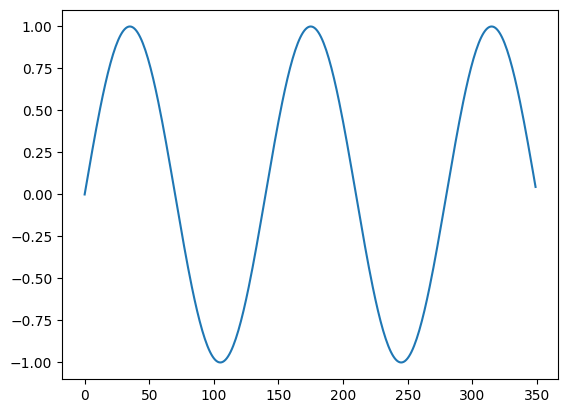

In [ ]:
# Feature Engineering: Positional Encoding (5th Harmonic)
Positional = np.sin(5 * np.pi * f * x1)  # Calculate sine function values
plt.plot(x1, Positional)

In [13]:
Phase1.shape,Positional.shape

((350,), (350,))

In [ ]:
# Create Batched Data Structure
# Repeat 1D traces to form 2D blocks (50 repetitions)
near_1s = np.tile(near_1S, (50, 1))
near_2s = np.tile(near_2S, (50, 1))
near_3s = np.tile(near_3S, (50, 1))
near_4s = np.tile(near_4S, (50, 1))
NEAR = np.concatenate((near_1s,near_2s,near_3s,near_4s),axis=0)

mid_1s = np.tile(mid_1S, (50, 1))
mid_2s = np.tile(mid_2S, (50, 1))
mid_3s = np.tile(near_3S, (50, 1)) # Note: potential copy paste error using near_3S
mid_4s = np.tile(near_4S, (50, 1)) # Note: potential copy paste error using near_4S
MID = np.concatenate((mid_1s,mid_2s,mid_3s,mid_4s),axis=0)

far_1s = np.tile(far_1S, (50, 1))
far_2s = np.tile(far_2S, (50, 1))
far_3s = np.tile(far_3S, (50, 1))
far_4s = np.tile(far_4S, (50, 1))
FAR = np.concatenate((far_1s,far_2s,far_3s,far_4s),axis=0)

In [ ]:
# Stack Seismic Channels
SYN = np.stack((NEAR,MID,FAR),axis = 2)
SYN.shape

(200, 350, 3)

In [ ]:
# Prepare Phase and Positional Features
Phase_1 = np.tile(Phase1, (50, 1))
Phase_2 = np.tile(Phase2, (50, 1))
Phase_4 = np.tile(Phase4, (50, 1))
Positiona_l = np.tile(Positional, (200, 1))
Positiona_l = np.expand_dims(Positiona_l,2)

In [ ]:
# Construct Phase Block
PHASE = np.concatenate((Phase_1,Phase_2,Phase_1,Phase_4), axis=0)
PHASE = np.expand_dims(PHASE,2)
PHASE.shape

(200, 350, 1)

In [ ]:
# Create Full Dataset (Seismic + Phase + Position)
# Note: In this notebook, this full dataset might not be used for training the main model
phase_data = np.concatenate((SYN,PHASE,Positiona_l),axis = 2)
phase_data.shape

(200, 350, 5)

In [ ]:
# Create 'NO_Phase' Dataset (Seismic + Position only)
# This excludes the Phase channels, leaving 4 channels (3 Seismic + 1 Position)
NO_phase_data = np.concatenate((SYN,Positiona_l),axis = 2)
NO_phase_data.shape

(200, 350, 4)

In [ ]:
# Select Training Samples from Full Dataset
Phase_train_data = np.stack((phase_data[25],phase_data[75],phase_data[175]),axis = 0)
Phase_train_data = np.expand_dims(Phase_train_data,2)
Phase_train_data.shape

(3, 350, 1, 5)

In [ ]:
# Select Training Samples from 'NO_Phase' Dataset
# This is the actual input used for training in this notebook
NO_Phase_train_data = np.stack((NO_phase_data[25],NO_phase_data[75],NO_phase_data[175]),axis = 0)
NO_Phase_train_data = np.expand_dims(NO_Phase_train_data,2)
NO_Phase_train_data.shape

(3, 350, 1, 4)

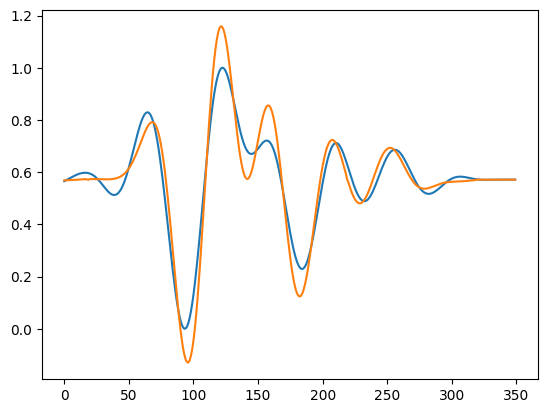

In [24]:
plt.plot(NO_Phase_train_data[0,:,0,0])
plt.plot(NO_phase_data[125,:,0])

In [ ]:
# Prepare Training Labels (Ground Truth)
train_vp = np.stack((VP_1,VP_2,VP_4),axis = 0)
train_vs = np.stack((VS_1,VS_2,VS_4),axis = 0)
train_den = np.stack((DEN_1,DEN_2,DEN_4),axis = 0)
train_label = np.stack((train_vp,train_vs,train_den),axis=2)
train_label.shape

(3, 350, 3)

In [ ]:
# Import Deep Learning Layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Multiply, Add, Permute, GRU
from tensorflow.keras.models import Model
import numpy as np
from scipy import signal
from pylops.utils.wavelets import ricker

In [ ]:
# Seismic Consistency Loss Function
# Computes synthetic seismic from predictions and compares with real seismic data
def reverse(data, Min, Max):
        sample = data * (Max - Min) + Min
        return sample
def seismic_loss1(S2_, predictions):
    vsvp = 0.5
    ntheta = 3
    thetamin, thetamax = 10, 30
    theta = np.linspace(thetamin, thetamax, ntheta)

    # index = [5,10,15.....]
    nt0 = train_label.shape[1]
    dt0 = 0.5e-3
    t0 = np.arange(nt0) * dt0
    ntwav = 180
    wavelet = ricker(t0[:ntwav//2+1], 25)[0]

    Re_FPVP = reverse(predictions[:, :, 0], VP_1min, VP_1max)
    Re_FPVS = reverse(predictions[:, :, 1], VS_1min, VS_1max)
    Re_FPDN = reverse(predictions[:, :, 2], DEN_1min, DEN_1max)
    
    Re_FP = tf.stack((Re_FPVP, Re_FPVS, Re_FPDN), axis=2)
    s1 = tf.math.log(Re_FP)

    SYN = tf.zeros((3, train_label.shape[1], ntheta), dtype=tf.float32)
    SYN_var = tf.Variable(SYN)

    for i in range(3):
        m = s1[i, :, :]
        PPop_dense = pylops.avo.prestack.PrestackLinearModelling(wavelet, theta, vsvp=vsvp, nt0=nt0, linearization="akirich", explicit=True)
        dPP_dense = PPop_dense * m.ravel()
        tf_reshaped = tf.reshape(dPP_dense, [1,nt0, ntheta,])
        SYN_var[i].assign(tf.cast(tf_reshaped, tf.float32))
    return tf.reduce_mean(tf.square(S2_ - SYN_var))

In [ ]:
# Well Logging Loss Function
# Supervised loss comparing predictions to ground truth well logs
def well_loss2(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [ ]:
# Low-Frequency Regularization Loss
# Constrains the low-frequency component of predictions
def lowmodel_loss3(y_true3, y_pred3):
    # Low-frequency component loss function example (customize as needed)
    nfilt = 3
    cutofffr = 0.03#
    b, a = signal.butter(nfilt, cutofffr)# 
   
    Vpprior = signal.filtfilt(b, a, y_pred3[:, :, 0])
    Vsprior = signal.filtfilt(b, a, y_pred3[:, :, 1])
    Rhobprior = signal.filtfilt(b, a, y_pred3[:, :, 2])
    
    Vpprior_label = signal.filtfilt(b, a, y_true3[:, :, 0])
    Vsprior_label = signal.filtfilt(b, a, y_true3[:, :, 1])
    Rhobprior_label = signal.filtfilt(b, a, y_true3[:, :, 2])
    
    Re_label = tf.stack((Vpprior_label,Vsprior_label,Rhobprior_label),axis = 2)
    Re_FP = tf.stack((Vpprior,Vsprior,Rhobprior),axis = 2)

    return tf.reduce_mean(tf.square(Re_label-Re_FP))

In [30]:
from tensorflow.keras.layers import Activation

In [ ]:
# Self-Attention Mechanism
# Captures long-range dependencies in the data
def attention_3d_block1(inputs): #10,32
    # inputs.shape = (batch_size, time_steps, lstm_units)
    # (batch_size, time_steps, lstm_units) -> (batch_size, lstm_units, time_steps)
    a = Permute((2, 1))(inputs) # 32,10  

    # (batch_size, lstm_units, time_steps) -> (batch_size, lstm_units, time_steps)
    DK = 63
    WQ = Dense(DK, activation='softmax')(a)  
    WK = Dense(DK, activation='softmax')(a)
    WV = Dense(DK, activation='softmax')(a)
    # (batch_size, time_steps，lstm_units )
    Q = tf.matmul(inputs,WQ) 
    K = tf.matmul(inputs,WK)
    V = tf.matmul(inputs,WV)
    # (batch_size, lstm_units, time_steps) -> (batch_size, time_steps, lstm_units)
    KT = Permute((2, 1), name='attention_vec')(K) # DK,32 

    score = tf.matmul(Q,KT) #DK,DK
    import math
    DK = math.sqrt(DK)
    res = score / DK  # 32 ,10 * 32,10
    X = Activation('softmax')(res)# 32,10
    result = tf.matmul(X,V) 
    return result

In [32]:
NO_Phase_train_data.shape,Phase_train_data.shape[-3:]

((3, 350, 1, 4), (350, 1, 5))

In [ ]:
# Build the Hybrid Model (CNN + GRU + Attention)
# "NO_face_model": Indicates this model version is designed to work without phase constraints (or with modified input)
def NO_face_model_SAGCN(input_size):
    # input_size=NO_Phase_train_data.shape[-3:]
    input_ = Input(input_size)
    
    conv1 = Conv2D(7, (3,3), padding="same", activation="relu")(input_)
    conv2 = Conv2D(9, (5,5), padding="same", activation="relu")(conv1)
    conv3 = Conv2D(9, (7,7), padding="same", activation="relu")(conv2)
    Spatial = Reshape((input_.shape[1], 9))(conv3)
    
    input_1 = Reshape((input_.shape[1], input_.shape[3]))(input_)
    G1 = GRU(9, return_sequences=True, activation='relu')(input_1)
    G2 = GRU(9, return_sequences=True, activation='relu')(G1)
    G3 = GRU(9, return_sequences=True, activation='relu')(G2)
    
    a = G3 + Spatial
    
    result = attention_3d_block1(a)
    
    flatten = Flatten()(result)
    output = Dense(input_.shape[1]*3)(flatten)
    output1 = Reshape((input_.shape[1],3))(output)
    face_model = Model(inputs=input_, outputs=output1)
    return face_model

In [ ]:
# Initialize Model and Optimizer
from tqdm import tqdm
NO_face_model = NO_face_model_SAGCN((350,1,4)) # Input shape corresponds to Time x 1 x Channels (Seismic+Positional)
optimizer = tf.keras.optimizers.Adam()

In [35]:
pos = Phase_train_data[:,:,:,[-2]]

In [ ]:
# Training Loop
# Trains the model using GradientTape to minimize the combined loss (Seismic + Well + LowFreq)
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
num_epochs = 300
for epoch in tqdm(range(num_epochs)):
    with tf.GradientTape() as tape:
        
        # Forward Pass: Use 'NO_Phase_train_data' which excludes phase info
        predictions = NO_face_model(NO_Phase_train_data[:,:,[0],:4], training=True)
        

        loss1 = seismic_loss1(Phase_train_data[:,:,0,:3], predictions)
        loss11 = tf.cast(loss1,tf.float32)
        loss2 = well_loss2(train_label, predictions)
        
        loss3 = lowmodel_loss3(train_label, predictions)
        # 
        total_loss = loss11 + loss2 + loss3      
        
    gradients = tape.gradient(total_loss, NO_face_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, NO_face_model.trainable_variables))

    # print(f"Epoch {epoch+1}, Total Loss: {total_loss.numpy()}, Loss1: {loss1.numpy()}, Loss2: {loss2.numpy()}, Loss3: {loss3.numpy()}")

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [22:16<00:00,  4.45s/it]


In [ ]:
# Prepare Inference Data
data = np.expand_dims(NO_phase_data,2)

In [ ]:
# Run Inference
pos_face_pred = NO_face_model(data[:,:,[0],:4], training=True)
pos_face_pred = np.array(pos_face_pred)

In [ ]:
# Denormalize Predictions
PrednoVP = reverse(pos_face_pred[:, :, 0], VP_1min, VP_1max)
PrednoVS = reverse(pos_face_pred[:, :, 1], VS_1min, VS_1max)
PrednoDN = reverse(pos_face_pred[:, :, 2], DEN_1min, DEN_1max)

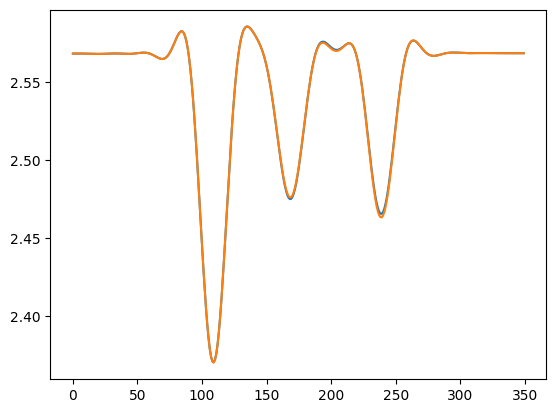

In [ ]:
# Plot Single Trace Comparison (Density)
i= 25
plt.plot(model_EI[i,:,2], label='True Density')
plt.plot(PrednoDN[i,:], label='Predicted Density')
plt.legend()
plt.show()

In [58]:
pos_face_pred.shape

(200, 350, 3)

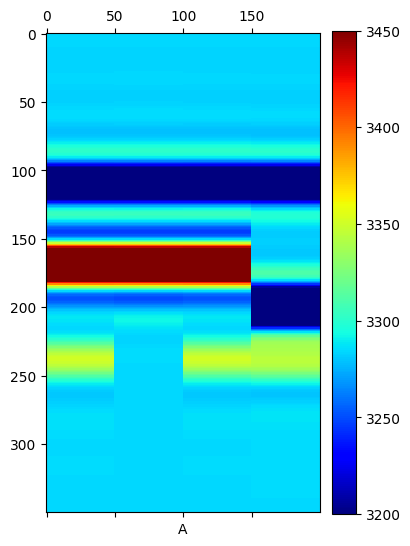

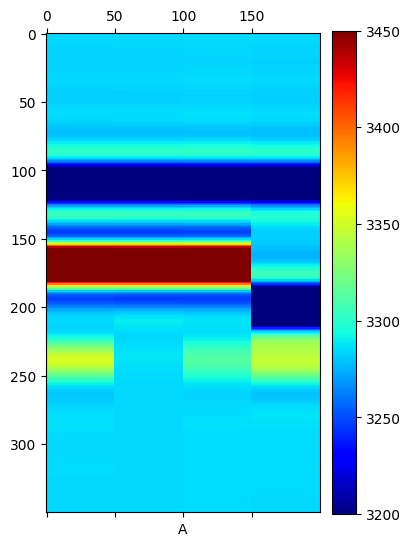

In [ ]:
# Visualize Vp Results
# Top: Ground Truth, Bottom: Predicted
plt.matshow(model_EI[:,:,0].T,cmap='jet',vmin = 3200,vmax = 3450)
plt.title('True Vp Model')
plt.xlabel('A')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()

plt.matshow(PrednoVP.T,cmap='jet',vmin = 3200,vmax = 3450)
plt.title('Predicted Vp Model')
plt.xlabel('A')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()

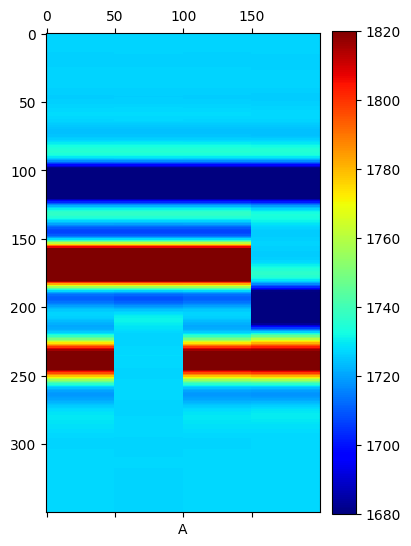

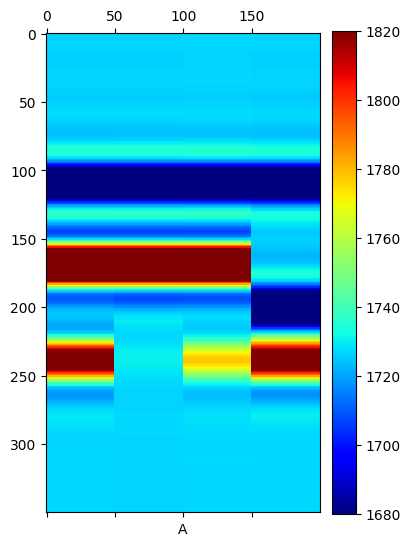

In [ ]:
# Visualize Vs Results
# Top: Ground Truth, Bottom: Predicted
plt.matshow(model_EI[:,:,1].T,cmap='jet',vmin = 1680,vmax = 1820)
plt.title('True Vs Model')
plt.xlabel('A')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()

plt.matshow(PrednoVS.T,cmap='jet',vmin = 1680,vmax = 1820)
plt.title('Predicted Vs Model')
plt.xlabel('A')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()

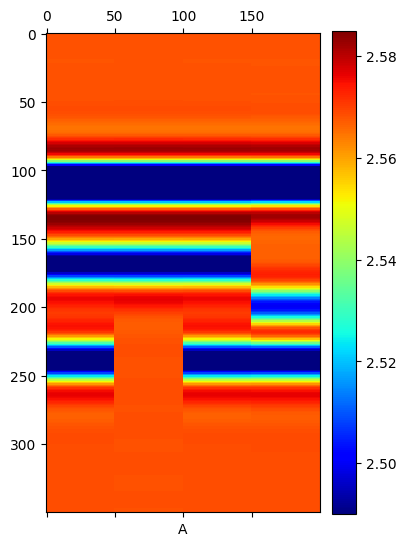

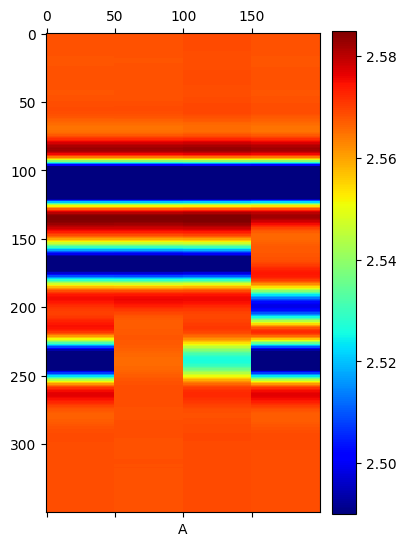

In [ ]:
# Visualize Density Results
# Top: Ground Truth, Bottom: Predicted
plt.matshow(model_EI[:,:,2].T,cmap='jet',vmin = 2.49,vmax = 2.585)
plt.title('True Density Model')
plt.xlabel('A')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()

plt.matshow(PrednoDN.T,cmap='jet',vmin = 2.49,vmax = 2.585)
plt.title('Predicted Density Model')
plt.xlabel('A')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()